# Processing waveform medical data
In this notebook, gait data from the Physionet `gaitndd` dataset will be processed and spectrograms of the signals will be created. Hopefully, the processed data will be used later on to train a deep learning classifier and to explore the possibilties of Generative Adversarial Networks for improving the classifier's performance.

## Set up
First, let's import some Python packages:
* `os` lets us interact with our operating system to save and load data
* `numpy` allows us to handle data as n-dimensional arrays
* SciPy's `signal` library includes useful functions for signal processing, including a function to generate spectrograms
* `pyplot` will be useful to visualize data
* `wfdb` is the __[native Python waveform-database package](https://pypi.org/project/wfdb/)__

In [1]:
import os
import numpy as np
import scipy.signal as sgn
import matplotlib.pyplot as plt
import wfdb

In [2]:
# Change PyPlot settings
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 9]

## Data exploration and visualization
Before processing the signals, let's take a look at the records directly downloaded from Physionet. This notebook assumes the `gaitndd` data has been properly downloaded from Physionet and stored in the `data/raw` directory in the root folder of this repository.

In [3]:
# list data files in directory
rootdir = os.pardir
files_list = os.listdir(os.path.join(rootdir, 'data/raw'))
print(sorted(files_list)[:5])

['als1.hea', 'als1.let', 'als1.rit', 'als10.hea', 'als10.let']


The `wfdb` package provides several functions to interact with the data. For example, we can plot all or just a portion of the signals in a specific record. We can also display relevant data corresponding to each record.

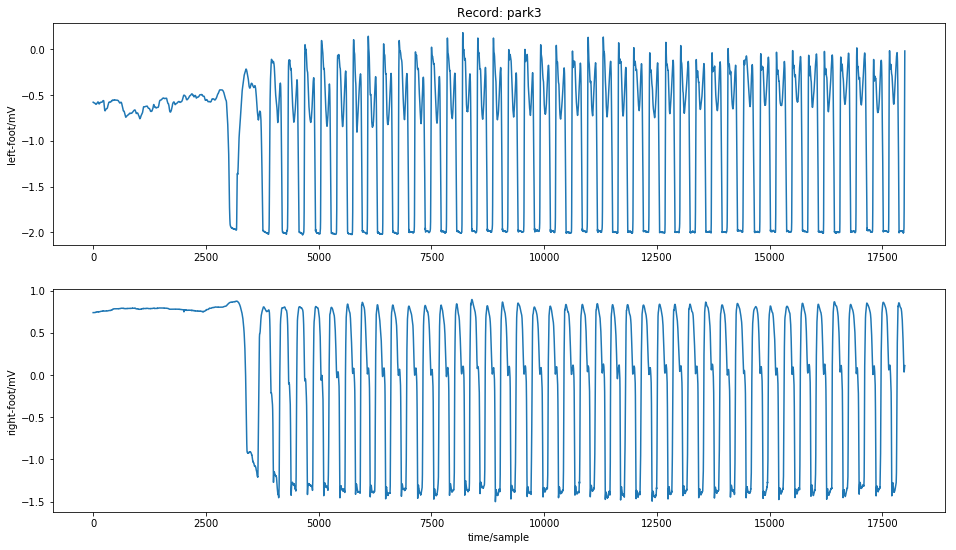

{'record_name': 'park3',
 'n_sig': 2,
 'fs': 300,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 18000,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['left-foot', 'right-foot'],
 'p_signal': array([[-0.578,  0.739],
        [-0.579,  0.739],
        [-0.579,  0.739],
        ...,
        [-0.123,  0.106],
        [-0.055,  0.109],
        [-0.018,  0.111]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['park3.let', 'park3.rit'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [1000.0, 1000.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [-578, 739],
 'checksum': [44836, 28842],
 'block_size': [0, 0]}

In [4]:
# plot the first minute of a record
test_record = wfdb.rdrecord(os.path.join(rootdir,'data/raw/park3'), sampfrom=0, sampto=18000)
wfdb.plot_wfdb(test_record)
# display the record's data
display(test_record.__dict__)

The `gaitndd` records all share the same characteristics. Each record has two signals, each corresponding to one foot. The sampling frequency is 300 Hz and the signals have 90000 sampling points, that is, the duration of each signal corresponds to 5 minutes.

## Handling missing values
After a close inspection of the raw data, it has been found that there are some missing data, expressed as ```NaN``` values.

In [4]:
n_fragments = 10

In [5]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [6]:
# go through directory, split signals and find fragments with missing values

in_dir = os.path.join(rootdir, 'data/raw')

fragments_with_nans = []

for in_filename in sorted(os.listdir(in_dir)):
    if in_filename.endswith('hea'):
        record_name = in_filename[:-4]
        record = wfdb.rdrecord(os.path.join(rootdir, 'data/raw', record_name), \
                               sampfrom=0, sampto=90000)
        
        signal = record.p_signal.T
        signal_right = signal[1, :]
        signal_left = signal[0, :]
        
        for i, fragment in enumerate(np.split(signal_right, n_fragments)):
            nans, t = nan_helper(fragment)
            num_of_nans = np.sum(nans)
            if num_of_nans != 0:
                fragments_with_nans.append((record_name + '_rit_' + str(i+1), num_of_nans))
        
        for i, fragment in enumerate(np.split(signal_left, n_fragments)):
            nans, t = nan_helper(fragment)
            num_of_nans = np.sum(nans)
            if num_of_nans != 0:
                fragments_with_nans.append((record_name + '_let_' + str(i+1), num_of_nans))

In [7]:
fragments_with_nans

[('als1_rit_1', 1),
 ('als12_rit_1', 1),
 ('als13_rit_1', 1),
 ('als5_rit_6', 2374),
 ('als5_rit_7', 6025),
 ('als5_rit_8', 6061),
 ('als5_rit_9', 6058),
 ('als5_rit_10', 6028),
 ('als7_rit_1', 1),
 ('als9_rit_1', 1),
 ('control2_let_1', 1),
 ('control3_rit_1', 1),
 ('control4_rit_1', 1),
 ('hunt13_rit_1', 48),
 ('hunt13_rit_2', 124),
 ('hunt13_rit_3', 64),
 ('hunt13_rit_4', 414),
 ('hunt13_rit_5', 400),
 ('hunt13_rit_6', 324),
 ('hunt13_rit_7', 502),
 ('hunt13_rit_8', 156),
 ('hunt13_rit_9', 166),
 ('hunt13_rit_10', 53),
 ('hunt4_rit_1', 1),
 ('hunt8_rit_1', 1),
 ('park14_rit_1', 1432),
 ('park14_rit_2', 432),
 ('park14_rit_7', 1),
 ('park14_rit_8', 32)]

In [8]:
len(fragments_with_nans)

29

In [26]:
sum([fragment[1] >= 50 for fragment in fragments_with_nans])

16

One possible solution is substituting those missing values with interpolated values. Another option is discarding the records that have a high number of missing values. For records with only a few missing values, the first solution seems reasonable. However, if there are too many missing values the records should be discarded.

Let's take a sample record with missing values and visualize what replacing the NaN entries with the interpolated values looks like.

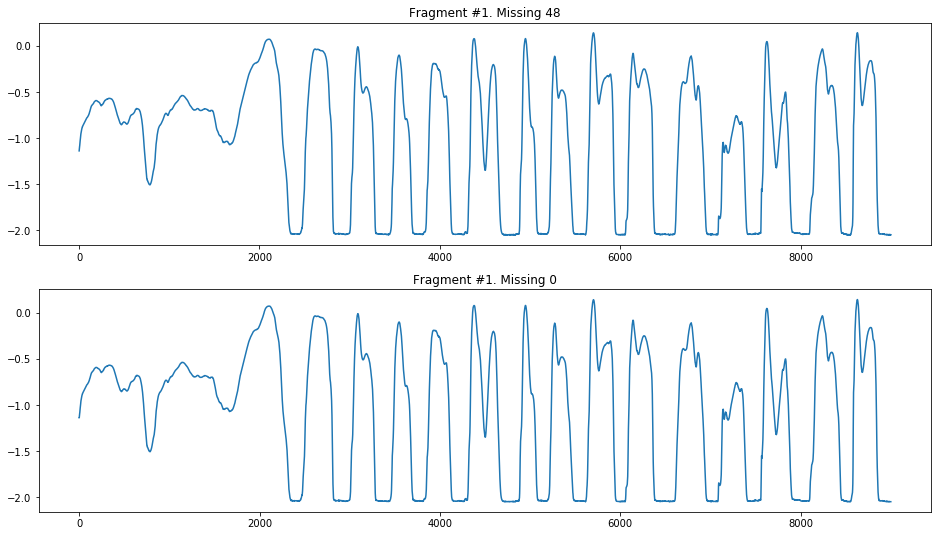

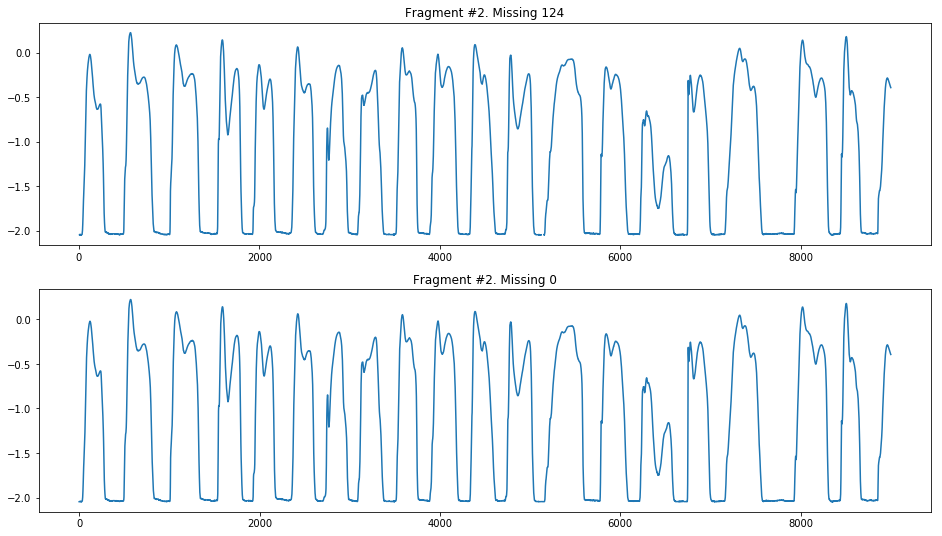

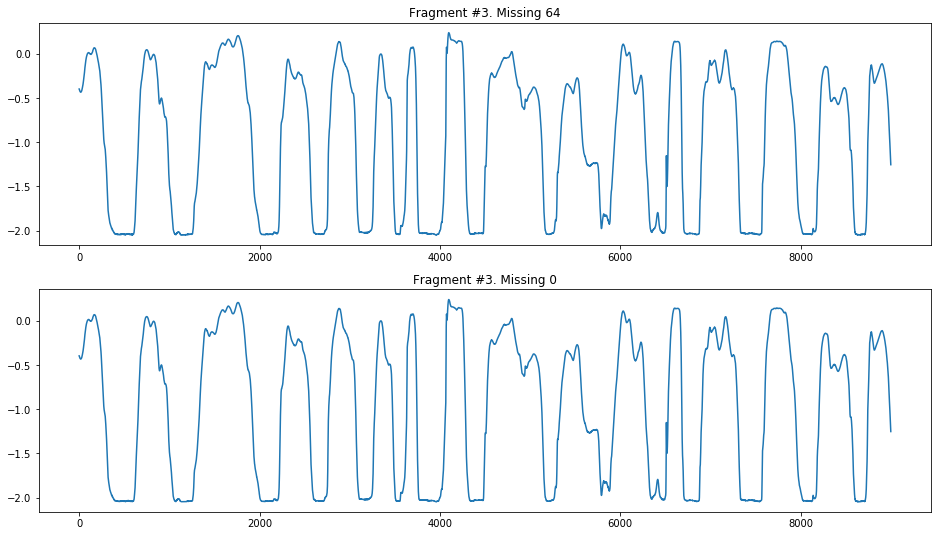

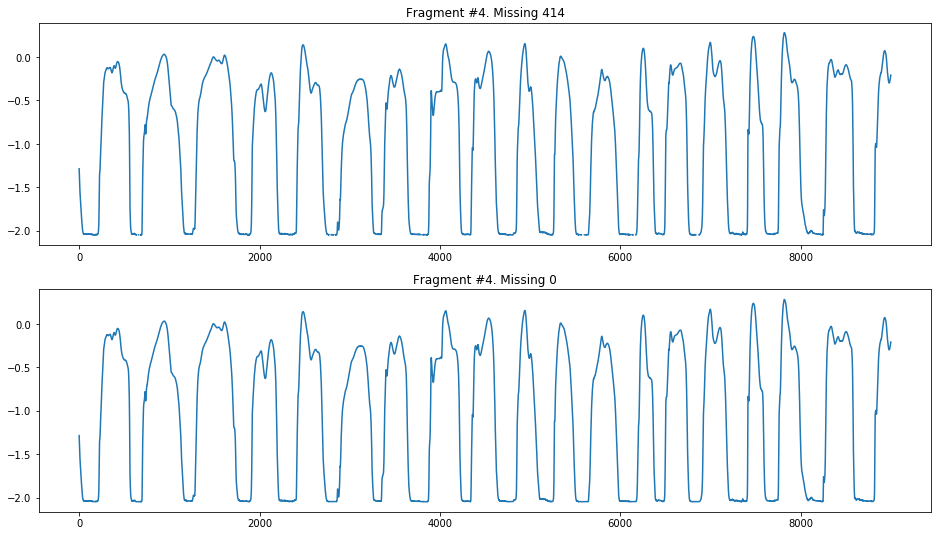

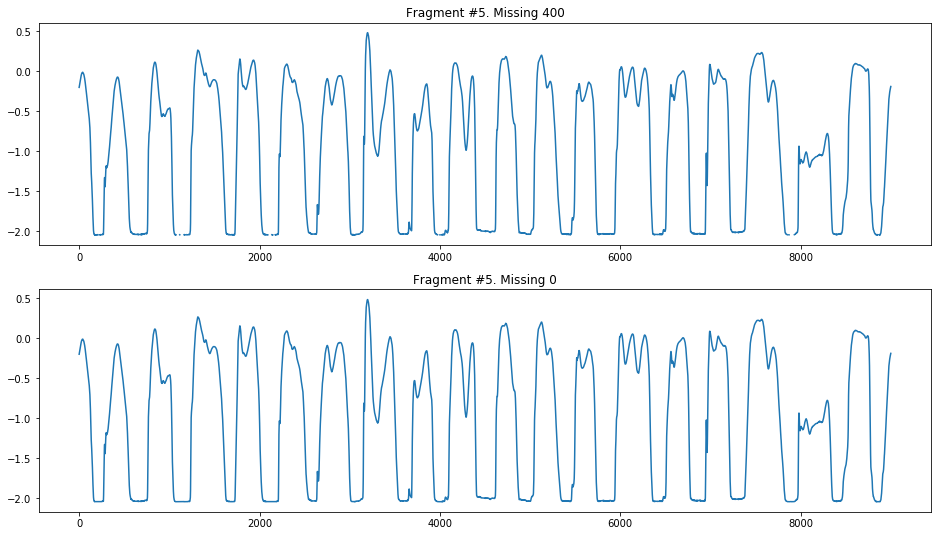

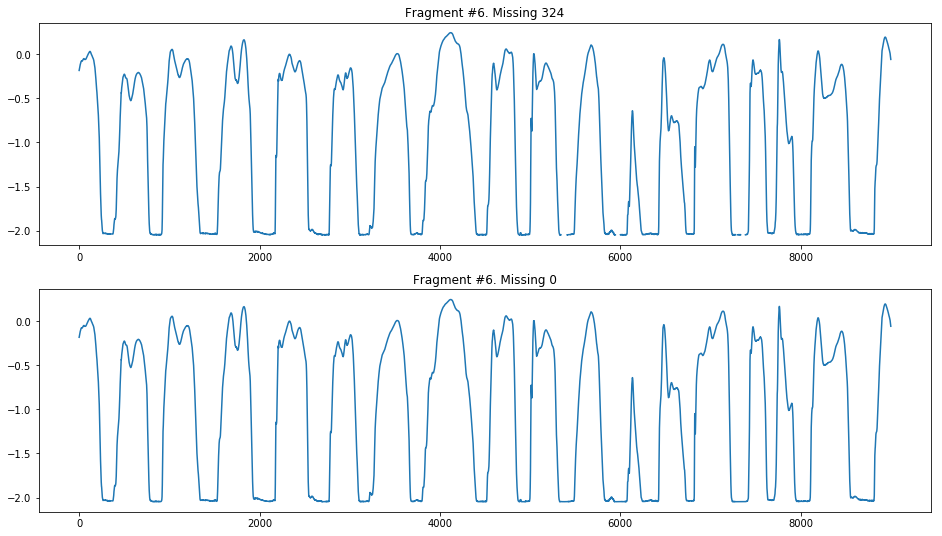

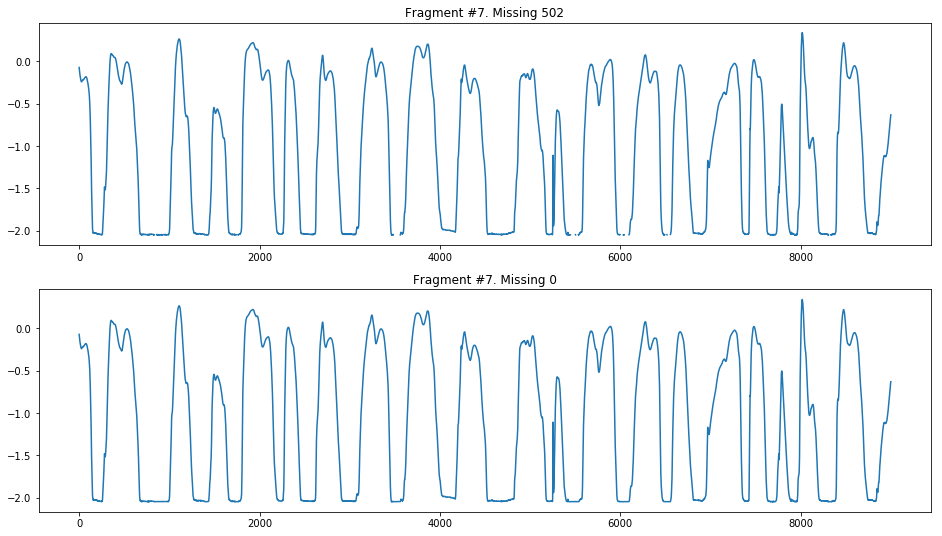

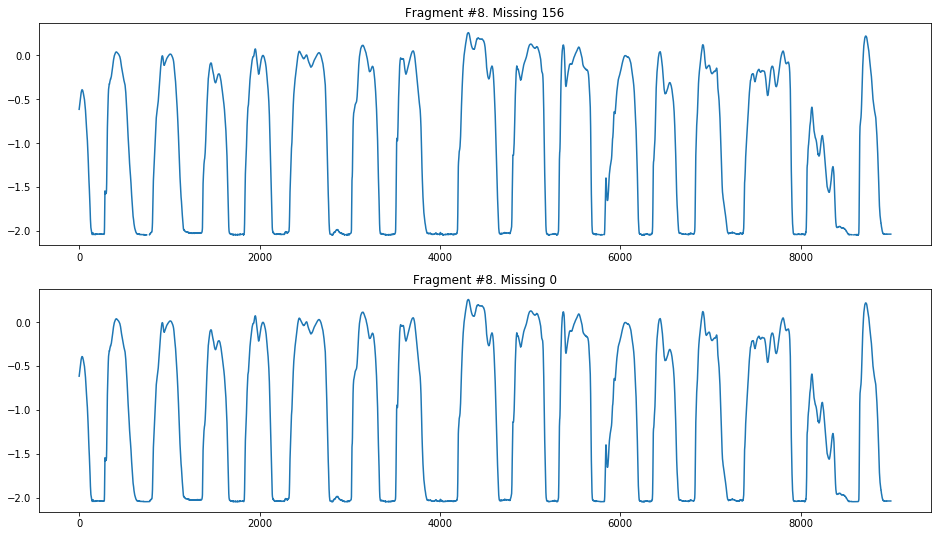

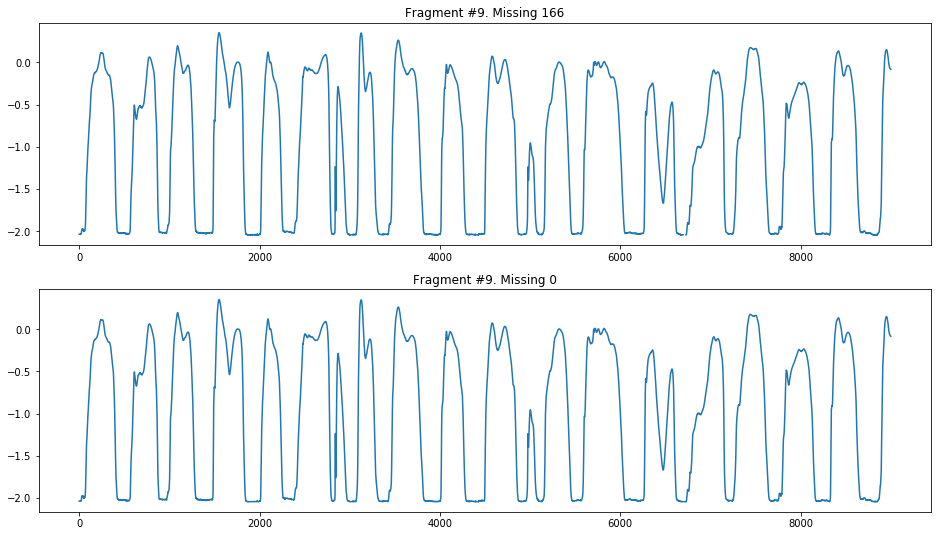

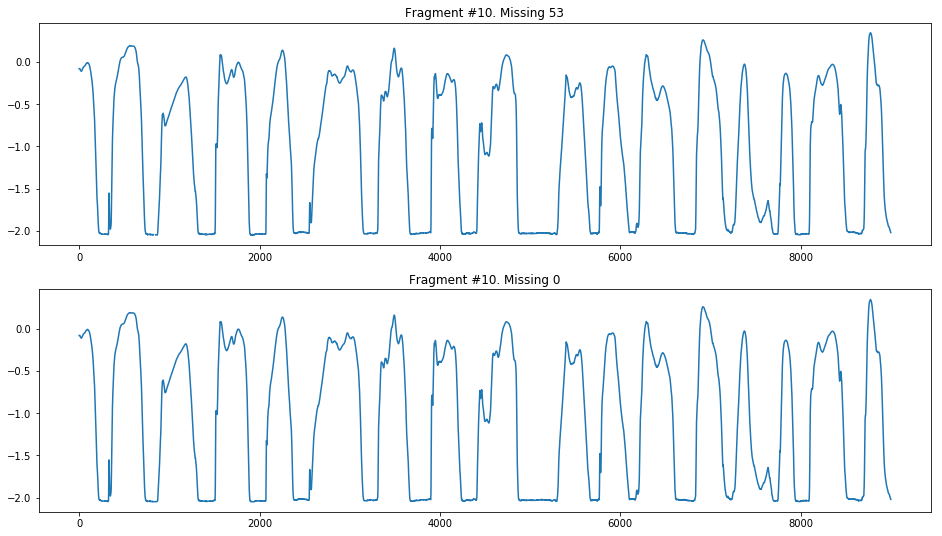

In [9]:
# test interpolating missing values. plot signals

record_name = 'hunt13'

record = wfdb.rdrecord(os.path.join(rootdir, 'data/raw', record_name), \
                       sampfrom=0, sampto=90000)

signal = record.p_signal.T
signal_right = signal[1, :]
signal_left = signal[0, :]

for i, fragment in enumerate(np.split(signal_right, n_fragments)):
    fig, axes = plt.subplots(nrows=2, ncols=1)
    nans, t = nan_helper(fragment)
    num_of_nans = np.sum(nans)
    
    axes[0].set_title('Fragment #{0}. Missing {1}'.format(i+1, num_of_nans))
    axes[0].plot(fragment)
    
    fragment[nans] = np.interp(t(nans), t(~nans), fragment[~nans])
    
    nans, t = nan_helper(fragment)
    num_of_nans = np.sum(nans)
    axes[1].set_title('Fragment #{0}. Missing {1}'.format(i+1, num_of_nans))
    axes[1].plot(fragment)

Interestingly, in this case, many of the missing values seem to correspond to parts where the signal tends to have an almost constant value during a significant range of time. It appears to correspond to the lower values of the signal as well, which appear to be saturated at a certain value.

## Splitting and normalizing signals
The records from the Physionet database will be split into 30 second segments.

The first segment of each record will be discarded, since it usually presents abnormal behaviour.

Segments with a number of NaN values above a threshold will be discarded as well. For now, fragments of signal with more than 50 missing values, which is just over 0.5 % of the sampling points in a 30 second segment signal (at 300 Hz sampling frequency).

Afterwards, the signal segments will be normalized to have zero mean and unit variances. Finally, they will be saved as as .npy files in the `data/interim/normalized-signals` directory, keeping the name of the original records.

In [15]:
out_dir = os.path.join(rootdir, 'data/interim/normalized-signals')
in_dir = os.path.join(rootdir, 'data/raw')

for in_filename in sorted(os.listdir(in_dir)):
    if in_filename.endswith('hea'):
        record_name = in_filename[:-4]
        record = wfdb.rdrecord(os.path.join(rootdir, 'data/raw', record_name), \
                               sampfrom=0, sampto=90000)
        
        signal = record.p_signal.T
        signal_right = signal[1, :]
        signal_left = signal[0, :]
        
        for i, fragment in enumerate(np.split(signal_right, n_fragments)[1:]):
            nans, t = nan_helper(fragment)
            num_of_nans = np.sum(nans) 
            
            if num_of_nans > 50:
                continue
            elif num_of_nans <= 50 and num_of_nans > 0:
                fragment[nans] = np.interp(t(nans), t(~nans), fragment[~nans])
            
            normalized = (fragment - fragment.mean()) / fragment.std()
            out_filename = os.path.join(out_dir, record_name + '_rit_' + str(i+2))
            np.save(out_filename, normalized)
        
        for i, fragment in enumerate(np.split(signal_left, n_fragments)[1:]):
            nans, t = nan_helper(fragment)
            num_of_nans = np.sum(nans) 
            
            if num_of_nans > 50:
                continue
            elif num_of_nans <= 50 and num_of_nans > 0:
                fragment[nans] = np.interp(t(nans), t(~nans), fragment[~nans])
            
            normalized = (fragment - fragment.mean()) / fragment.std()
            out_filename = os.path.join(out_dir, record_name + '_let_' + str(i+2))
            np.save(out_filename, normalized)

After visual inspection of the signal segments, some records were found to have abnormal behaviour, consisting mainly of what looked like long periods in which the patient did not walk. These records have been added to a "blacklist" and will be removed from the dataset.

In [21]:
# read signal segment names from blacklist.txt and add them to list
filename = os.path.join(rootdir, 'data/external/blacklist.txt')
blacklist = []
with open(filename, 'r') as handle:
    for line in handle.readlines():
        blacklist.append(line.strip() + '.npy')

In [22]:
blacklist

['als12_let_10.npy',
 'als12_let_3.npy',
 'als12_let_4.npy',
 'als12_let_7.npy',
 'als12_let_8.npy',
 'als12_let_9.npy',
 'als12_rit_10.npy',
 'als12_rit_3.npy',
 'als12_rit_4.npy',
 'als12_rit_7.npy',
 'als12_rit_8.npy',
 'als12_rit_9.npy',
 'als1_let_10.npy',
 'als1_rit_10.npy',
 'als4_let_4.npy',
 'als4_let_8.npy',
 'als4_let_9.npy',
 'als4_rit_4.npy',
 'als4_rit_8.npy',
 'als4_rit_9.npy',
 'als5_let_6.npy',
 'hunt14_let_8.npy',
 'hunt14_rit_8.npy',
 'hunt15_let_10.npy',
 'hunt15_rit_10.npy',
 'park11_let_4.npy',
 'park11_let_5.npy',
 'park11_let_7.npy',
 'park11_rit_4.npy',
 'park11_rit_5.npy',
 'park11_rit_7.npy',
 'park7_let_9.npy',
 'park7_rit_9.npy']

In [23]:
for file in os.listdir(out_dir):
    if file in blacklist:
        os.remove(os.path.join(out_dir, file))

In the end, 1104 signal segments are kept, which will be used to build a training and testing data set

## Spectrograms
Now, spectrograms of each normalized signal fragment will be created. The `signal` library from SciPy will be used for this task.

A spectrogram enables us to represent the characteristics of a signal in both time and frequency domains. It is constructed by windowing the signal with a window function at regular intervals, finding the Discrete Fourier Transform of said windowed interval and calculating the magnitude of each frequency element. The result is an image or matrix that shows the evolution of a signal's frequency contents over time.

More information on the Discrete Fourier Transform and spectrograms can be found in this useful __[lecture](https://www.youtube.com/watch?v=g1_wcbGUcDY&list=PLR0sTNXahBFVWbTPvENIbUW2NG-eNUCCs&index=2&t=0s)__

Although the spectrogram is a great tool to visualize the evolution of a signal, there is always a tradeoff between frequency and time resolution. Particularly, the frequency resolution (size of each frequency "bin") is given by $res = \frac{f_s}{L}$, with $L$ being the window width. If a wide window is used, the frequency resolution will be very good, but it will be harder to capture changes of the signal in the time domain. On the contrary, if a narrow window is used, quick changes in time will be captured well but the frequency content will not be accurately represented. The window width is a critical parameter. Other important parameters for the spectrogram are:

* The window function (gaussian, triangular, Hamming,...)
* The overlap between segments

Finally, it shoud be mentioned that the highest frequency that the Discrete Fourier Transform is able to represent, also know as the Nyquist frequency, is $f_{Nyquist} = \frac{f_s}{2}$. In this case, the Nyquist frequency is 75 Hz but, given that human gait data presents very low frequencies, we will only keep the frequency contents below 7 Hz.

### Comparison of spectrograms using different parameters

For a single example, let's compare the spectograms that result from different parameters, namely window width, window function and overlap degree.

In [5]:
out_dir = os.path.join(rootdir, 'data/interim/spectrograms')
in_dir = os.path.join(rootdir, 'data/interim/normalized-signals')

# take an example record from the dataset
signal = np.load(os.path.join(in_dir, 'hunt1_let_3.npy'))
fs = 300
freq_max = 7

#### Window width

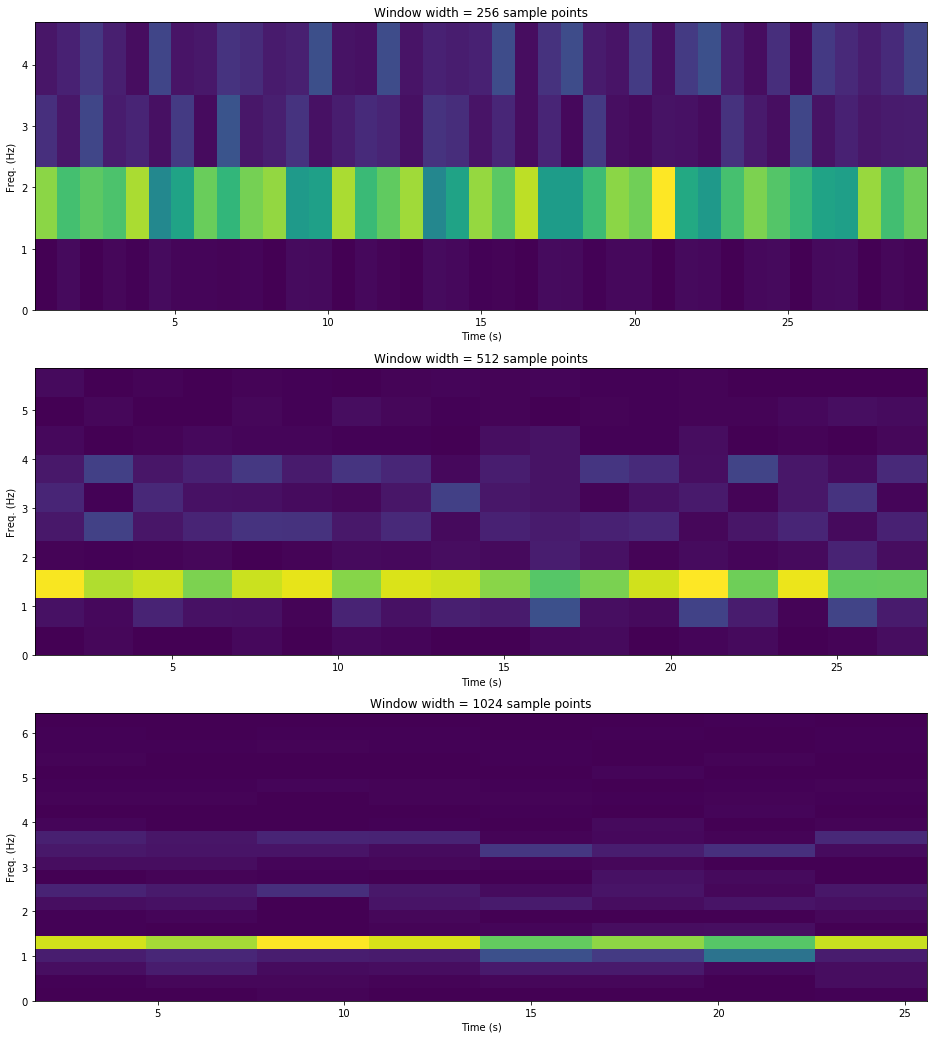

In [12]:
# compare window widths
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 18))

for i in range(3):
    L = 256 * (2 ** i)
    f, t, Sxx = sgn.spectrogram(signal, nperseg=L)
    f_limit = freq_max * L // fs # index corresponding to the max freq that we are inteterested in
    axes[i].pcolormesh(t / fs, f[0:f_limit] * fs, np.abs(Sxx[0:f_limit]))
    axes[i].set_title('Window width = {0} sample points'.format(L))
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Freq. (Hz)')

In the spectrograms above, the tradeoff between frequency and time resolution can be seen as the width of the window changes.

#### Window function

Text(0, 0.5, 'Freq. (Hz)')

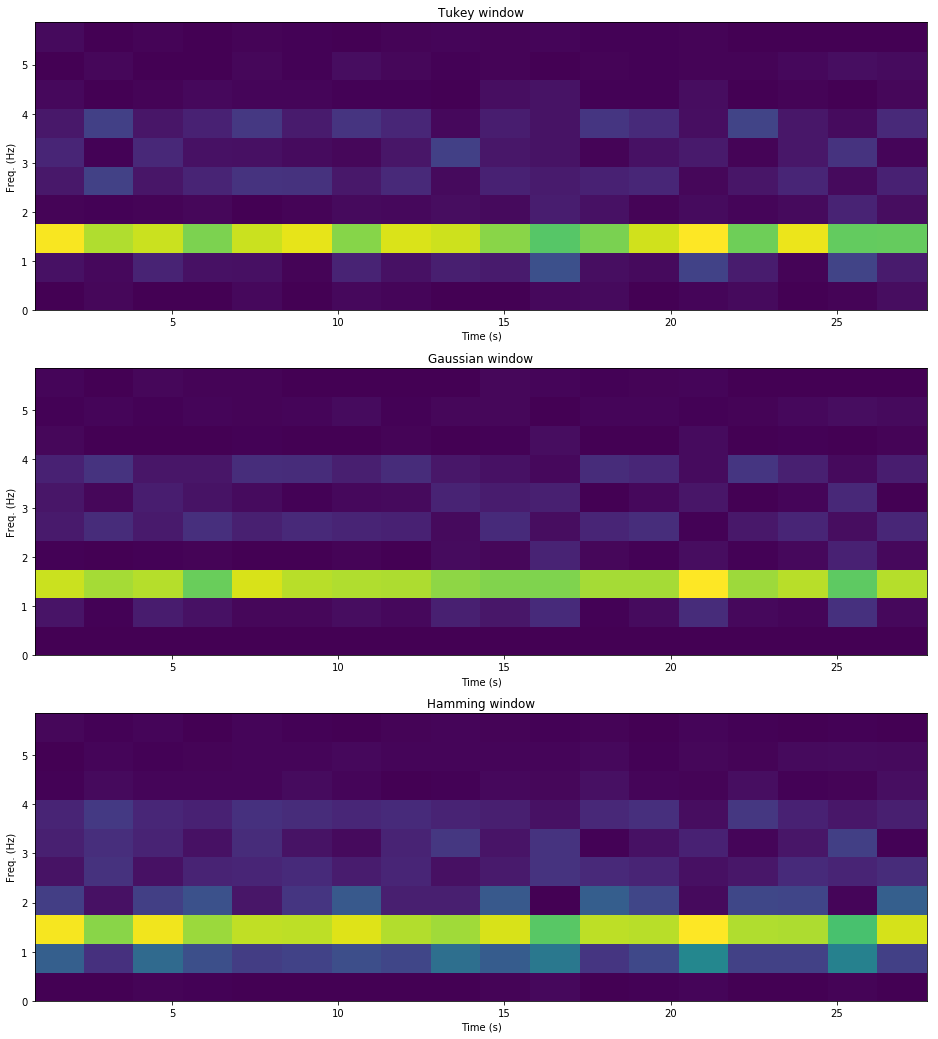

In [13]:
# compare window functions
L = 512
f_limit = freq_max * L // fs

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 18))

# tukey window
f, t, Sxx = sgn.spectrogram(signal, nperseg=L, window=('tukey', 0.25))
axes[0].pcolormesh(t / fs, f[0:f_limit] * fs, np.abs(Sxx[0:f_limit]))
axes[0].set_title('Tukey window')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Freq. (Hz)')

# gaussian window
f, t, Sxx = sgn.spectrogram(signal, nperseg=L, window=('gaussian', 512/2))
axes[1].pcolormesh(t / fs, f[0:f_limit] * fs, np.abs(Sxx[0:f_limit]))
axes[1].set_title('Gaussian window')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Freq. (Hz)')

# triangular window
f, t, Sxx = sgn.spectrogram(signal, nperseg=L, window='hamming')
axes[2].pcolormesh(t / fs, f[0:f_limit] * fs, np.abs(Sxx[0:f_limit]))
axes[2].set_title('Hamming window')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Freq. (Hz)')

For this set of parameters, changing the window function does not seem to affect the overall aspect of the spectrogram very much.

#### Overlap degree

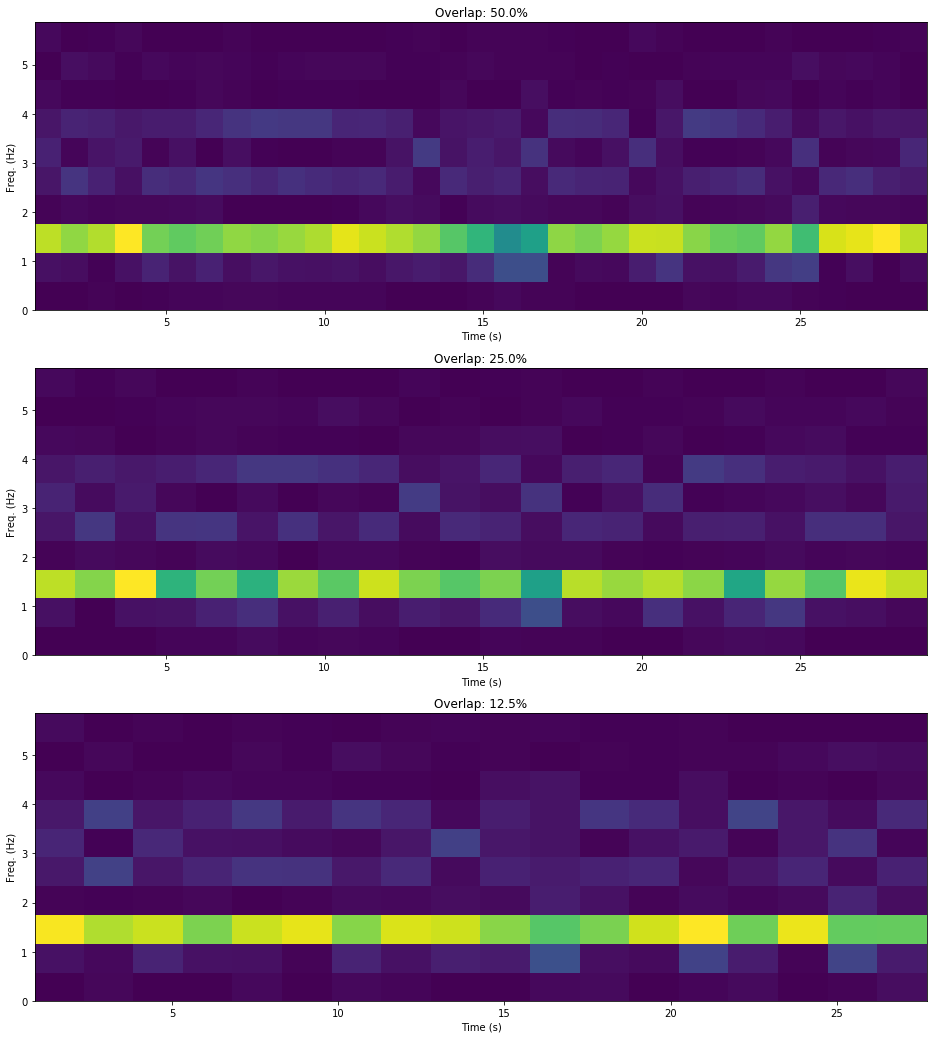

In [14]:
# compare different degrees of overlap between segments
L = 512
f_limit = freq_max * L // fs

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 18))

for i in reversed(range(3)):
    overlap = 1 / (2 ** (i + 1))
    f, t, Sxx = sgn.spectrogram(signal, nperseg=L, noverlap=overlap*L)
    axes[i].pcolormesh(t / fs, f[0:f_limit] * fs, np.abs(Sxx[0:f_limit]))
    axes[i].set_title('Overlap: {0}%'.format(overlap * 100))
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Freq. (Hz)')

Overlapping is said to reduce the effects of windowing. Window functions tend to zero on the sides, which can lead to information loss. By overlapping a fraction of the points taken in each segment this effect is reduced. Note that these does not necessarily result in a higher temporal resolution.

### Comparison of spectrograms between diseases


If a classifier is to be trained, it would be interesting to know how the spectrograms of gait data corresponding to different diseases compare to one another. Here, a spectrogram is created from one record (only the left-foot signal in this case) from each neuro-degenerative disease in the dataset, as well as for a control (healthy) subject.

Text(0, 0.5, 'Freq. (Hz)')

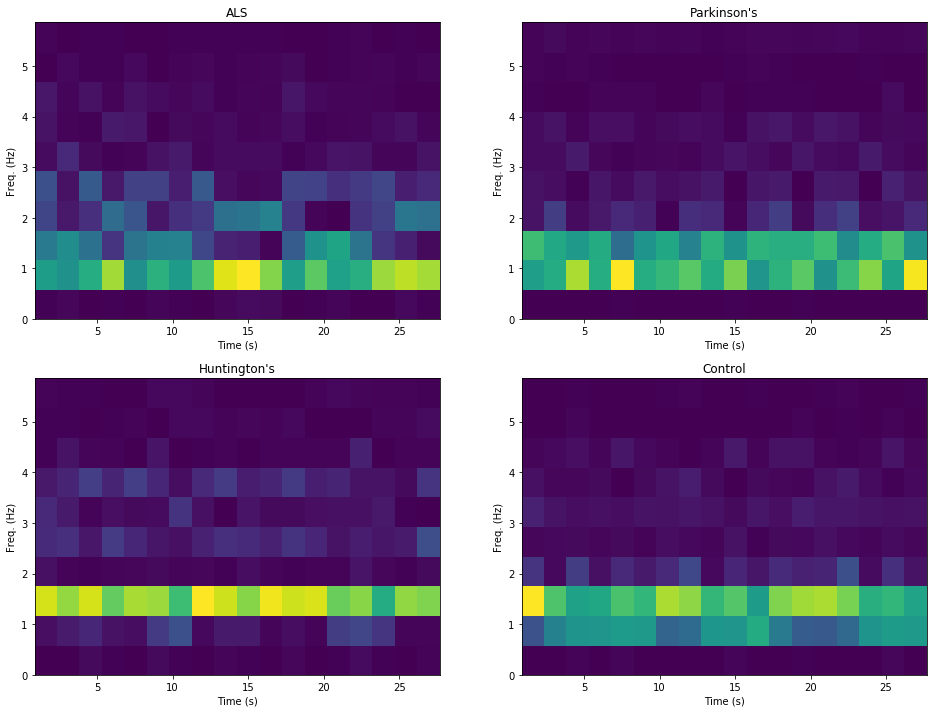

In [15]:
L = 512
fs = 300
f_limit = freq_max * L // fs

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# ALS
signal = np.load(os.path.join(in_dir, 'als1_let_2.npy'))
f, t, Sxx = sgn.spectrogram(signal, nperseg=L)
axes[0,0].pcolormesh(t / fs, f[0:f_limit] * fs, Sxx[0:f_limit])
axes[0,0].set_title('ALS')
axes[0,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('Freq. (Hz)')

# Parkinson's disease
signal = np.load(os.path.join(in_dir, 'park1_let_2.npy'))
f, t, Sxx = sgn.spectrogram(signal, nperseg=L)
axes[0,1].pcolormesh(t / fs, f[0:f_limit] * fs, Sxx[0:f_limit])
axes[0,1].set_title('Parkinson\'s')
axes[0,1].set_xlabel('Time (s)')
axes[0,1].set_ylabel('Freq. (Hz)')

# Huntington's disease
signal = np.load(os.path.join(in_dir, 'hunt1_let_2.npy'))
f, t, Sxx = sgn.spectrogram(signal, nperseg=L)
axes[1,0].pcolormesh(t / fs, f[0:f_limit] * fs, Sxx[0:f_limit])
axes[1,0].set_title('Huntington\'s')
axes[1,0].set_xlabel('Time (s)')
axes[1,0].set_ylabel('Freq. (Hz)')

# control subject
signal = np.load(os.path.join(in_dir, 'control1_let_2.npy'))
f, t, Sxx = sgn.spectrogram(signal, nperseg=L)
axes[1,1].pcolormesh(t / fs, f[0:f_limit] * fs, Sxx[0:f_limit])
axes[1,1].set_title('Control')
axes[1,1].set_xlabel('Time (s)')
axes[1,1].set_ylabel('Freq. (Hz)')

### Saving the spectrograms
We can save the spectrograms of all signal files in a new directory `data/interim/spectrograms`

For now, the configuration will be the following:
* Window width of 512 points
* Window overlap of 1/2
* Hamming window function
* Only the frequencies below 6 Hz will be kept

In [25]:
# go through all the files, create their respective spectrograms and save as .npz files
out_dir = os.path.join(rootdir, 'data/interim/spectrograms')
in_dir = os.path.join(rootdir, 'data/interim/normalized-signals')

L = 512
fs = 300
freq_max = 7
f_limit = freq_max * L // fs

for in_filename in os.listdir(in_dir):
    signal = np.load(os.path.join(in_dir, in_filename))
    f, t, Sxx = sgn.spectrogram(signal, nperseg=L, window='hamming', noverlap=L//2)
    f = f[0:f_limit] * fs
    t = t / fs
    Sxx = Sxx[0:f_limit]
    out_filename = in_filename[:-4]
    np.savez(os.path.join(out_dir, out_filename), f=f, t=t, Sxx=Sxx)

## Conclusions and further work
Regarding the raw signal processing, the original Physionet gaitndd records have been split into one minute segments and normalized to have zero mean and unit variance. In most records, the signal gives the impression that the patients do not start walking until a few seconds have passed. Thus, it may be interesting to discard part of the signal in order to better represent the true gait dynamic of patients.

Additionally, a set of spectrograms has been constructed thanks to SciPy's `signal` package. The effect of some parameters such as the window width has been shown. However, the intricacies of the parameters involved still need further study in order to build images that represent the signal data accurately in a way that is representative of each disease.